In [1]:
import xarray as xr
import rioxarray as riox
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re
import numpy as np

In [7]:
yr = 2022
prefix='cper'
ds = riox.open_rasterio('data/gcloud/hls_' + prefix + '_' + str(yr) + '_gcloud.nc', masked=True)#.chunk(sngl_chunks)
ds['date'] = [datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S') for x in ds['date'].values]
ds['date'] = ds['date'].dt.date
ds = ds.where(ds < ds.attrs['_FillValue'])
ds = ds.where(ds != np.inf)
#ds

In [8]:
yr_comp = 2020
ds_comp = riox.open_rasterio('data/gcloud/hls_' + prefix + '_' + str(yr_comp) + '_gcloud.nc', masked=True)#.chunk(sngl_chunks)
ds_comp['date'] = [datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S') for x in ds_comp['date'].values]
ds_comp['date'] = ds_comp['date'].dt.date
ds_comp = ds_comp.where(ds_comp < ds.attrs['_FillValue'])
ds_comp = ds_comp.where(ds_comp != np.inf)
ds_comp_dates = (ds_comp['date'] + timedelta(days=365*(yr-yr_comp) + 1)).values
if len(ds_comp_dates) == 366:
    ds_comp_dates = [x for x in ds_comp_dates if x.year == yr]
    ds_comp = ds_comp.where(ds_comp['date'] != datetime(yr_comp, 2, 29).date(), drop=True)

In [9]:
ds_ndvi_lta = riox.open_rasterio('data/ee_lta/' + prefix + '_ee_ndvi_landsat_wkly_lta.nc', masked=True)

In [10]:
ds_ndvi_lta['date'] = [datetime.strptime(re.sub('2020', str(yr), str(x)),'%Y-%m-%d %H:%M:%S') for x in ds_ndvi_lta['date'].values]

In [11]:
ds_ndvi_lta['date'] = ds_ndvi_lta['date'].dt.date

In [12]:
ds_ndvi_lta = ds_ndvi_lta.reindex({'y': ds.y, 'x': ds.x}, method='nearest', tolerance=30)#.isnull().all()

In [13]:
cmap = plt.cm.tab10

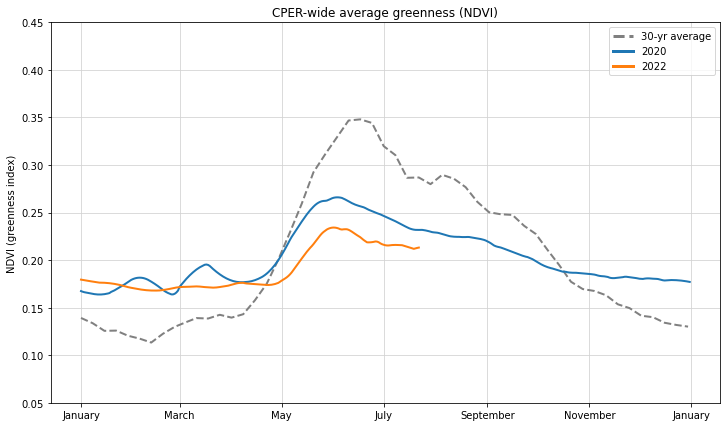

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(ds_ndvi_lta.date.values, ds_ndvi_lta.mean(dim=['y', 'x']).values, color='grey', linestyle='dashed',  linewidth=2)
ax.plot(ds_comp_dates, ds_comp['NDVI'].mean(dim=['y', 'x']).values,  linewidth=2)
ax.plot(ds.date.values, ds['NDVI'].mean(dim=['y', 'x']).values,  linewidth=2)
ax.grid(color='lightgrey', axis='both')
plt.ylim(0.05, 0.45)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='grey', linestyle='dashed', lw=3),
                Line2D([0], [0], color=cmap(0), lw=3),
                Line2D([0], [0], color=cmap(1), lw=3)]
ax.legend(custom_lines, ['30-yr average', '2020', '2022'])
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%B')
ax.xaxis.set_major_formatter(myFmt)
plt.ylabel('NDVI (greenness index)')
plt.title('CPER-wide average greenness (NDVI)')
plt.savefig('/mnt/c/Users/TBGPEA-Sean/Desktop/CARM_NDVI_update_2022.png', dpi=300)